In [1]:
import numpy as np
import math
import tensorflow as tf
%load_ext tensorboard
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
leakyRelU_weight = 0.1

In [3]:
def trapezoidIntegral(vals, ds):
    pass1 = tf.reduce_sum(vals, axis=0)
    pass2 = tf.reduce_sum(vals[1:-1], axis=0)
    return ds/2.0*(pass1+pass2)
def TFconv(image, filt, b):
    return tf.nn.convolution(input=image, filters=filt, padding="SAME") + b
def leakyRelUInv(x):
    shape = x.shape
    zeros = tf.zeros(shape)
    mask = tf.math.greater_equal(x, zeros)
    weighted = x / leakyRelU_weight
    return tf.where(mask, x, weighted)

In [4]:
def loopTFuSoln(x0, inFilt, pFilt, b):
    t1 = inFilt.shape[0]
    ds = 1.0/(t1-1)
    input_shape = x0.shape
    bzero = tf.zeros([inFilt.shape[4]])
    x = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    u = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    
    with tf.GradientTape() as tape:
        tape.watch(x0)
        u0 = leakyRelUInv(x0)
        u = u.write(0,TFconv(u0, inFilt[0], bzero))

        for h in range(t1-1):
            x = x.write(h, tf.nn.leaky_relu(u.read(h), alpha=leakyRelU_weight))
            zInt = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
            for s in range(h+1):
                zInt = zInt.write(s, TFconv(x.read(s), pFilt[s,h], b[h] / ((h+1)*ds)))
            z = trapezoidIntegral(zInt.stack(), ds)
            u = u.write(h+1, z + TFconv(u0, inFilt[h+1], bzero))
        x = x.write(t1-1,tf.nn.leaky_relu(u.read(t1-1), alpha=leakyRelU_weight))
        
        loss = tf.math.square(x.read(t1-1) - x0)
        gradients = tape.gradient(loss, [pFilt, inFilt, b])
        #optimizer.apply_gradients(zip(gradients, [pFilt, inFilt, b]))
        
        return tf.math.reduce_sum(loss), gradients

In [5]:
t0 = 5
t1 = t0+1
input_shape = (1,5,5)
filter_shape = (1,1,3,3)



actWt = [.1, 1] #leakyRelU: first number is slope left of origin, second number is slope right of origin

np.set_printoptions(suppress=True)
rng = np.random.default_rng(42)
uIn = rng.standard_normal(input_shape, dtype=np.float32)
iFilt = rng.standard_normal((t1,*filter_shape), dtype=np.float32)
paramFilt = rng.standard_normal((t1,t1,*filter_shape), dtype=np.float32)
biasVec = rng.standard_normal((t1,1), dtype=np.float32)

#xOut, uOut = uSoln(uIn, dt, iFilt, paramFilt, biasVec)
#print(xOut)

In [13]:
TFuIn = tf.expand_dims(tf.transpose(tf.convert_to_tensor(uIn, dtype=tf.float32), perm=[1,2,0]), 0)

TFiFiltTensor = tf.transpose(tf.compat.v1.get_variable("iFiltTensor", initializer=iFilt), perm=[0,3,4,1,2])
TFiFilt = tf.Variable(TFiFiltTensor, name="iFilt")

TFpFiltTensor = tf.transpose(tf.compat.v1.get_variable("pFiltTensor", initializer=paramFilt), perm=[0,1,4,5,2,3])
TFpFilt = tf.Variable(TFpFiltTensor, name="pFilt")

TFbiasVec = tf.compat.v1.get_variable("biasVec", initializer=biasVec)

#TFxOut, TFuOut = TFuSoln(TFuIn, dt, TFiFilt, TFpFilt, TFbiasVec)
#print(tf.transpose(TFuOut, perm=[4,0,1,2,3]))

In [7]:
TFloopUSoln = tf.function(loopTFuSoln)
tf.config.run_functions_eagerly(False)

In [17]:
TFuIn

<tf.Tensor: shape=(1, 5, 5, 1), dtype=float32, numpy=
array([[[[ 0.14190717],
         [-1.6685079 ],
         [-1.332108  ],
         [ 0.58255345],
         [ 0.3740366 ]],

        [[ 1.7554446 ],
         [ 0.13962899],
         [ 0.41919115],
         [-0.52172035],
         [-0.1815749 ]],

        [[-0.85166216],
         [ 2.568927  ],
         [ 1.0554465 ],
         [-0.7322652 ],
         [-0.78643155]],

        [[ 1.4023651 ],
         [-0.34617117],
         [ 0.09137221],
         [-1.1877912 ],
         [ 0.40984577]],

        [[ 0.4553142 ],
         [ 0.5972486 ],
         [ 0.3428611 ],
         [ 1.2612802 ],
         [ 0.34195012]]]], dtype=float32)>

In [8]:
def optimize(optimizer, uIn, iFilt, pFilt, bias):
    loss, grad = TFloopUSoln(uIn, iFilt, pFilt, bias)
    optimizer.apply_gradients(zip(grad, [pFilt, iFilt, bias]))
    return loss

In [14]:
learning_rate = 0.1
opt = tf.keras.optimizers.Adam(learning_rate)

iterations = 100
losses = []
for i in np.arange(iterations):
    losses.append(optimize(opt, TFuIn, TFiFilt, TFpFilt, TFbiasVec))

Text(0, 0.5, 'Simple Sum Loss')

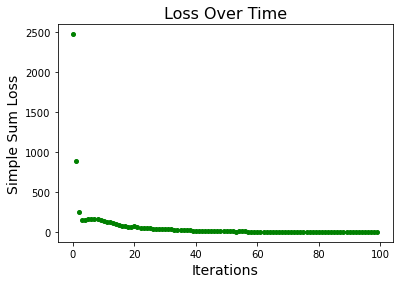

In [15]:
plt.plot(losses, "go", ms=4)
plt.title("Loss Over Time", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Simple Sum Loss", fontsize=14)

In [16]:
losses[99]

<tf.Tensor: shape=(), dtype=float32, numpy=4.517622>